# MultiSensor Dataset Preparation 
- Experiment data: March 2024. Aluminum, Laser-Wire DED
- Aurthor: Chen Lequn

### Notebook 2c: Signal Visualization

- Visualize time-series images and signals for analysis

### 1. Import necessary libraries

In [31]:
import torchaudio
import matplotlib.pyplot as plt
import librosa.display
import torchaudio.transforms as transforms
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import matplotlib.gridspec as gridspec
import numpy as np
import librosa
from PIL import Image
import matplotlib.colorbar as colorbar
from moviepy.editor import VideoFileClip

In [116]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'pre-processing')
os.makedirs(IMAGE_PATH, exist_ok=True)

# Change to desirable location of the raw dataset
Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset"
Annotation_file_path = os.path.join(Multimodal_dataset_PATH, "Annotation")
Dataset_path = os.path.join(Multimodal_dataset_PATH, 'Dataset')
final_audio_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "audio")
final_image_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "thermal_images")
              
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.50

In [3]:
def extract_frames_and_audio(video_path, start_time, duration, output_folder, frame_rate=10):
    """
    Extract frames from a video at a specified frame rate and the corresponding audio segment starting from a specified time for a given duration.
    
    Parameters:
    - video_path (str): Path to the video file.
    - start_time (float): Start time in seconds.
    - duration (float): Duration in seconds.
    - output_folder (str): Folder to save the extracted frames and audio.
    - frame_rate (int): Frame extraction rate in Hz (default is 10 Hz).
    """
    os.makedirs(output_folder, exist_ok=True)
    
    # Extract the corresponding audio segment
    clip = VideoFileClip(video_path)
    segmented_clip = clip.subclip(start_time, start_time + duration)
    audio_filename = os.path.join(output_folder, 'extracted_audio.wav')
    segmented_clip.audio.write_audiofile(audio_filename)
    print(f'Extracted audio from {start_time} to {start_time + duration} seconds and saved to {audio_filename}.')
    
    # Extract frames at the specified frame rate
    frame_output_folder = os.path.join(output_folder, 'frames')
    os.makedirs(frame_output_folder, exist_ok=True)
    
    for i in range(int(duration * frame_rate)):
        time_point = start_time + i / frame_rate  # time in seconds
        frame = clip.get_frame(time_point)
        output_filename = f"frame_{i+1}.jpg"
        output_path = os.path.join(frame_output_folder, output_filename)
        image_bgr = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, image_bgr)
    
    print(f'Extracted frames from {start_time} to {start_time + duration} seconds at {frame_rate} Hz and saved to {frame_output_folder}.')


### Image and Audio extraction

In [132]:
# Example usage
video_path = '/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/Raw_Video/Aluminium/avi/Exp_24.avi'
start_time = 45  # Start from 10 seconds
duration = 10  # Visualize 2 seconds
output_folder = '/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/Visualization_demo'
extract_frames_and_audio(video_path, start_time, duration, output_folder)

MoviePy - Writing audio in /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/Visualization_demo/extracted_audio.wav


MoviePy - Done.
Extracted audio from 45 to 55 seconds and saved to /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/Visualization_demo/extracted_audio.wav.


Extracted frames from 45 to 55 seconds at 10 Hz and saved to /home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/Visualization_demo/frames.


### Visualizing audio and transforms

In [133]:
def combined_visualization(audio_path, cmap='viridis'):
    """
    Visualize audio signal waveform, spectrogram, Mel-spectrogram, and MFCCs.
    
    Parameters:
    - audio_path (str): Path to the audio file.
    """
    # Load and process the audio file
    waveform, sample_rate = torchaudio.load(audio_path)
    
    # Create transformations with specified parameters
    spectrogram = transforms.Spectrogram(n_fft=1024)(waveform)
    mel_spectrogram = transforms.MelSpectrogram(sample_rate=44100, n_mels=64, n_fft=1024, hop_length=256)(waveform)
    mfcc = transforms.MFCC(sample_rate=44100, n_mfcc=13, melkwargs={'n_fft': 1024, 'n_mels': 64, 'hop_length': 256})(waveform)
    
    # Create the figure with subplots
    fig, axs = plt.subplots(4, 1, figsize=(8, 9), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
    
    # Define a function to add colorbar
    def add_colorbar(im, ax):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        plt.colorbar(im, cax=cax)
    
    # Plot the waveform
    time_axis = [i / sample_rate for i in range(waveform.size(1))]
    axs[0].plot(time_axis, waveform.t().numpy().squeeze())
    axs[0].set_title('Waveform', fontsize=16, pad=10)
    axs[0].set_xlabel('Time [sec]', fontsize=14)
    axs[0].set_ylabel('Amplitude', fontsize=14)
    axs[0].tick_params(axis='both', which='major', labelsize=12)
    axs[0].grid('--', alpha=0.5)
    
    # Plot the spectrogram
    im1 = axs[1].imshow(spectrogram.log2()[0,:,:].numpy(), cmap=cmap, origin='lower', aspect='auto',
                        extent=[0, waveform.size(1) / sample_rate, 0, spectrogram.size(1)])
    axs[1].set_title('Spectrogram', fontsize=16, pad=10)
    axs[1].set_xlabel('Time [sec]', fontsize=14)
    axs[1].set_ylabel('Frequency [Hz]', fontsize=14)
    axs[1].tick_params(axis='both', which='major', labelsize=12)
    add_colorbar(im1, axs[1])
    
    # Plot the Mel-spectrogram
    im2 = axs[2].imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap=cmap, origin='lower', aspect='auto',
                        extent=[0, waveform.size(1) / sample_rate, 0, mel_spectrogram.size(1)])
    axs[2].set_title('Mel-Spectrogram', fontsize=16, pad=10)
    axs[2].set_xlabel('Time [sec]', fontsize=14)
    axs[2].set_ylabel('Mel Frequency', fontsize=14)
    axs[2].tick_params(axis='both', which='major', labelsize=12)
    add_colorbar(im2, axs[2])
    
    # Plot the MFCCs
    im3 = axs[3].imshow(mfcc[0,:,:].numpy(), cmap=cmap, origin='lower', aspect='auto',
                        extent=[0, waveform.size(1) / sample_rate, 0, mfcc.size(1)])
    axs[3].set_title('MFCCs', fontsize=16, pad=10)
    axs[3].set_xlabel('Time [sec]', fontsize=14)
    axs[3].set_ylabel('MFCC Coefficients', fontsize=14)
    axs[3].tick_params(axis='both', which='major', labelsize=12)
    add_colorbar(im3, axs[3])
    
    plt.tight_layout()
    plt.show()

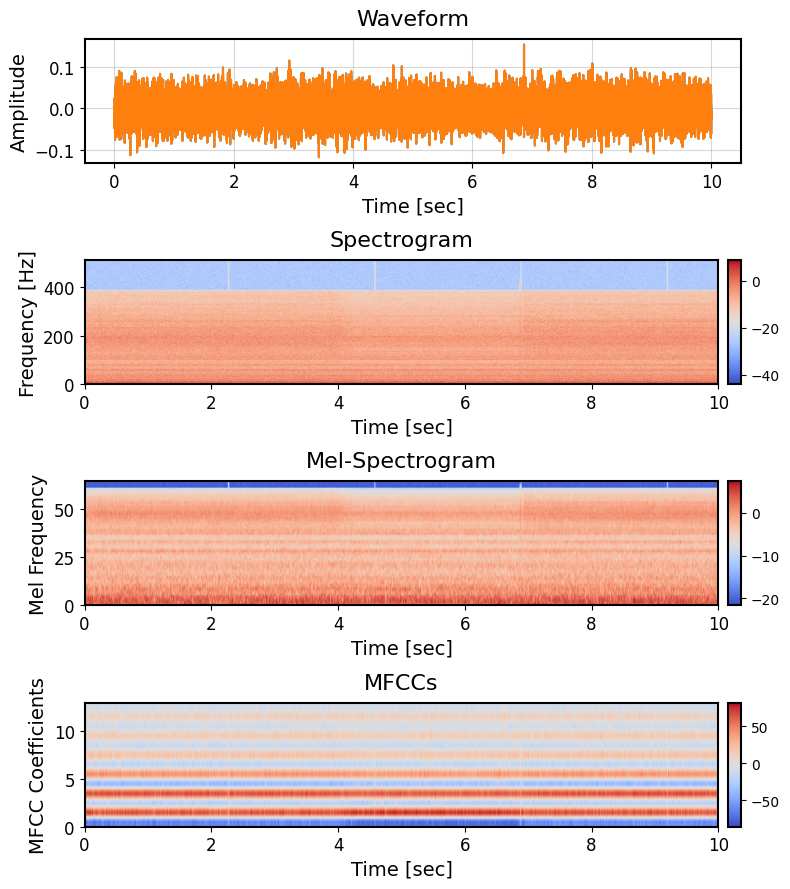

In [134]:
# Example usage
audio_path = '/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/Visualization_demo/extracted_audio.wav'
start_time = 10  # Start from 10 seconds
duration = 2  # Visualize 2 seconds
combined_visualization(audio_path, 'coolwarm')

In [143]:
def combined_visualization_librosa(audio_path, cmap='viridis'):
    """
    Visualize audio signal waveform, spectrogram, Mel-spectrogram, and MFCCs using librosa.
    
    Parameters:
    - audio_path (str): Path to the audio file.
    - cmap (str): Colormap for the plots.
    """
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Create transformations with specified parameters
    spectrogram = np.abs(librosa.stft(y, n_fft=1024))**2
    S_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=1024, hop_length=256, fmax=sr//2)
    mel_S_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, hop_length=256, n_mfcc=20)
    
    # Create the figure with subplots
    fig, axs = plt.subplots(4, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
    
    # Define a function to add colorbar
    def add_colorbar(im, ax, label):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(label, size=14, labelpad=10)
    
    # Plot the waveform
    # time_axis = np.linspace(0, len(y) / sr, len(y))
    # axs[0].plot(time_axis, y, linewidth=1)
    # axs[0].set_title('Raw acoustic signal', fontsize=16, pad=10)
    # axs[0].set_xlabel('Time [sec]', fontsize=14)
    # axs[0].set_ylabel('Amplitude', fontsize=14)
    # axs[0].tick_params(axis='both', which='major', labelsize=12)
    # axs[0].grid(alpha=0.3)


    img = librosa.display.waveshow(y, sr=sr, alpha=0.9, ax=axs[0])
    # axs[0].plot(time_axis, y, linewidth=1)
    axs[0].set_title('Raw acoustic signal', fontsize=16, pad=10)
    axs[0].set_xlabel('Time [sec]', fontsize=14)
    axs[0].set_ylabel('Amplitude', fontsize=14)
    axs[0].tick_params(axis='both', which='major', labelsize=12)
    axs[0].grid("-",alpha=0.3)
    
    # Plot the spectrogram
    img1 = librosa.display.specshow(S_db, sr=sr, hop_length=256, x_axis='time', y_axis='log', ax=axs[1], cmap=cmap)
    axs[1].set_title('Spectrogram', fontsize=16, pad=10)
    axs[1].set_xlabel('Time [sec]', fontsize=14)
    axs[1].set_ylabel('Frequency [Hz]', fontsize=14)
    axs[1].tick_params(axis='both', which='major', labelsize=12)
    axs[1].set_yticks([0, 256, 1024, 4096, 16384])
    add_colorbar(img1, axs[1], 'dB')
    
    # Plot the Mel-spectrogram
    img2 = librosa.display.specshow(mel_S_db, sr=sr, hop_length=256, x_axis='time', y_axis='mel', fmax=sr//2, ax=axs[2], cmap=cmap)
    axs[2].set_title('Mel-Spectrogram', fontsize=16, pad=10)
    axs[2].set_xlabel('Time [sec]', fontsize=14)
    axs[2].set_ylabel('Frequency [Hz]', fontsize=14)
    axs[2].tick_params(axis='both', which='major', labelsize=12)
    axs[2].set_yticks([0, 1024, 4096, 16384])
    add_colorbar(img2, axs[2], 'dB')
    
    # Plot the MFCCs
    img3 = librosa.display.specshow(mfccs, sr=sr, hop_length=256, x_axis='time', y_axis='mel', ax=axs[3], cmap=cmap, vmin=-200)
    axs[3].set_title('MFCCs', fontsize=16, pad=10)
    axs[3].set_xlabel('Time [sec]', fontsize=14)
    axs[3].set_ylabel('Frequency [Hz]', fontsize=14)
    axs[3].tick_params(axis='both', which='major', labelsize=12)
    axs[3].set_yticks([0, 1024, 4096, 16384])
    add_colorbar(img3, axs[3], 'MFCC Coefficients')
    
    plt.tight_layout()
    plt.show()

### Case one: Overheating - Laser Off - Overheating

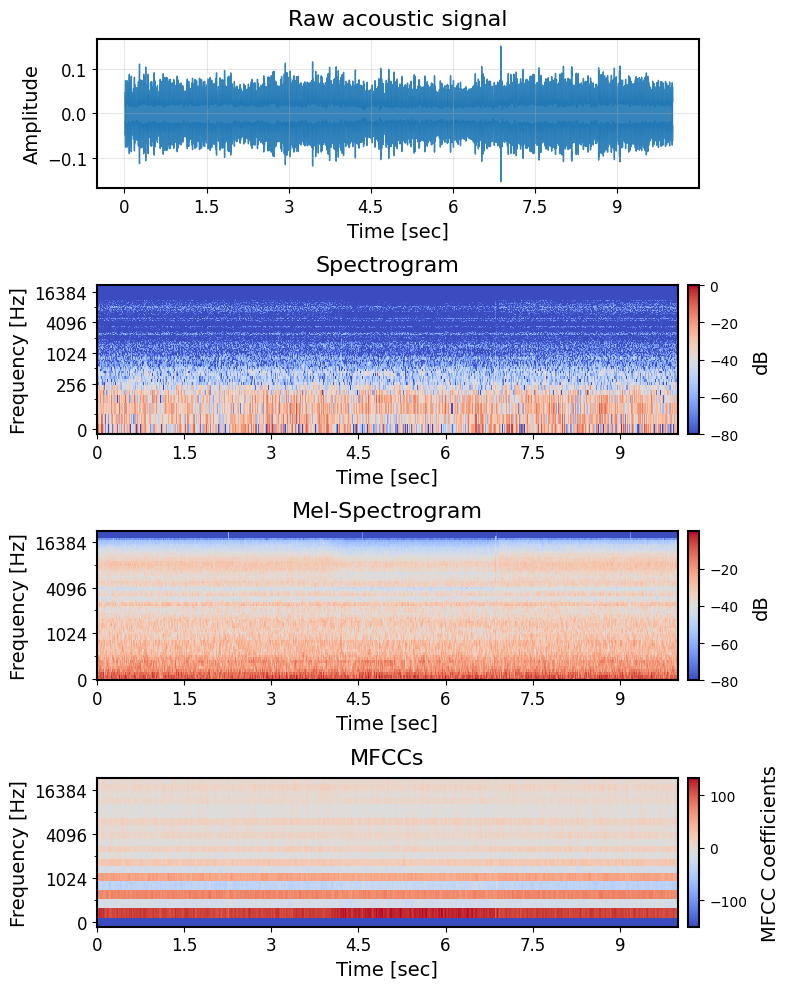

In [144]:
# Example usage
audio_path = '/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/Visualization_demo/extracted_audio.wav'
combined_visualization_librosa(audio_path, cmap='coolwarm') #magma, coolwarm, cividis, viridis